In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
model = torchvision.models.vgg16(pretrained=True).eval()
sumie.utils.remove_inplace(model)
sumie.utils.max_to_avg_pool(model)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU()
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1,

In [10]:
import math

class CompositeImage(torch.nn.Module):
    
    def __init__(self, im1, im2, transforms):
        super(CompositeImage, self).__init__()
        self.im1 = im1
        self.im2 = im2
        self.transforms = torch.nn.Sequential(*transforms)
        
    def forward(self):
        batched = torch.cat((self.im1(), self.im2))
        return self.transforms(batched)
    
    def get_image(self):
        return self.im1()

def change_scale(opt, i):
    opt.image.transforms[-2].factor *= (10 ** (1/1024))
    
imsize = 512
url = 'https://upload.wikimedia.org/wikipedia/commons/3/36/Vassily_Kandinsky%2C_1912_-_Improvisation_27%2C_Garden_of_Love_II.jpg'
#url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/The_Fighting_Temeraire%2C_JMW_Turner%2C_National_Gallery.jpg/640px-The_Fighting_Temeraire%2C_JMW_Turner%2C_National_Gallery.jpg'
#url = 'https://www.tate.org.uk/art/images/work/N/N05/N05058_10.jpg'
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/Leonard_Nimoy_by_Gage_Skidmore.jpg/459px-Leonard_Nimoy_by_Gage_Skidmore.jpg'
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Smiling_Woman_%28Imagicity_1145%29.jpg/1024px-Smiling_Woman_%28Imagicity_1145%29.jpg'

#url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/Florecillas.jpg/729px-Florecillas.jpg'
base_image = sumie.io.load_url(url, size=(imsize, imsize))
im = sumie.Image(imsize, param='fft', transforms=[])

device = 'cuda'

RuntimeError: number of dims don't match in permute

  0%|          | 0/1024 [00:00<?, ?it/s]/data/home/justin/code/sumie/venv/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|██████████| 1024/1024 [03:29<00:00,  1.38it/s]


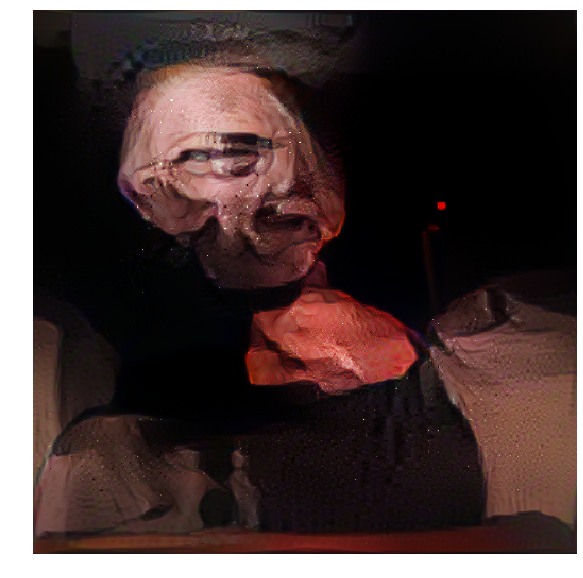

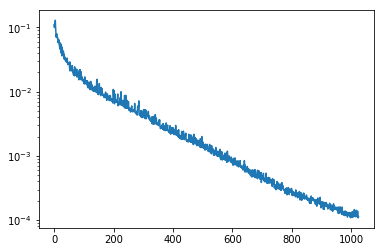

In [4]:
im.to(device)
model.to(device)

combined_im = CompositeImage(im, base_image.to(device), 
                             [
                    sumie.transforms.PositionJitter(16),
                    sumie.transforms.ScaleJitter(1.01),
                    sumie.transforms.PositionJitter(16),
                    sumie.transforms.Interpolate(0.1),
                    sumie.transforms.Normalise(),
                             ])
combined_im.to(device)
styles = []
for i in [5, 7, 10, 14, 17, 24]:
    styles.append(sumie.objectives.BatchMatchActivations(model.features[i], 0, 1, func=lambda x: sumie.utils.gram_matrix(x.unsqueeze(0))))
content = sumie.objectives.Composite(styles, weights=[1, 2, 4, 8, 100, 1000])
    
opt = sumie.Optimiser(combined_im, model.features, content)
opt.add_callback(change_scale)
opt.run(iterations=1024, lr=0.05, progress=True)
sumie.vis.show(im.get_image(), figsize = (10, 10))
plt.semilogy([-1*x.item() for x in opt.history])

In [5]:
w = [1, 2, 4, 8, 100, 1000]
for child, wi in zip(content.children, w):
    print(wi*child.objective)

tensor(-2.8490e-06, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-2.8969e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-8.8208e-06, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-4.0040e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-2.4383e-05, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-8.4141e-06, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 1024/1024 [01:42<00:00,  2.54it/s]


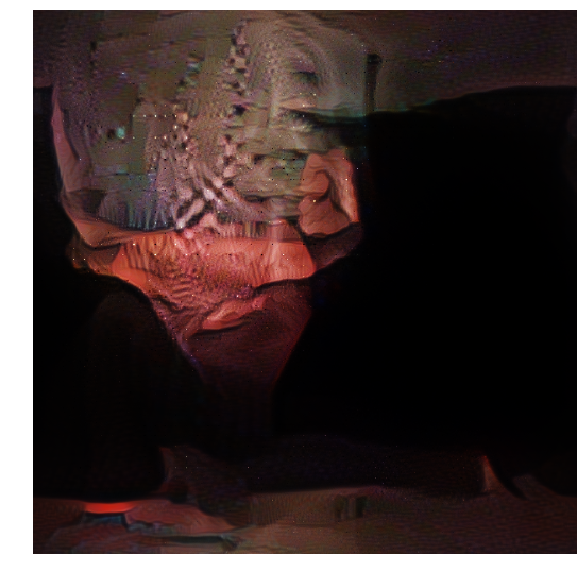

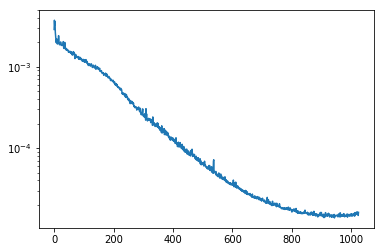

In [6]:
im = sumie.Image(imsize, param='fft', transforms=[
                    sumie.transforms.PositionJitter(16),
                    sumie.transforms.ScaleJitter(1.01),
                    sumie.transforms.PositionJitter(16),
                    sumie.transforms.Interpolate(0.1),
                    sumie.transforms.Normalise(),])

device = 'cuda'
im.to(device)
model.to(device)

combined_im.to(device)
style_list = [5, 7, 10, 14, 17, 24]
styles = [model.features[i] for i in style_list]
style = sumie.objectives.Style(sumie.utils.normalise(base_image).to(device), model.features, styles)
opt = sumie.Optimiser(im, model.features, style)
opt.add_callback(change_scale)
opt.run(iterations=1024, lr=0.05, progress=True)
sumie.vis.show(im.get_image(), figsize = (10, 10))
plt.semilogy([-1*x.item() for x in opt.history])

100%|██████████| 50/50 [00:02<00:00, 18.91it/s]


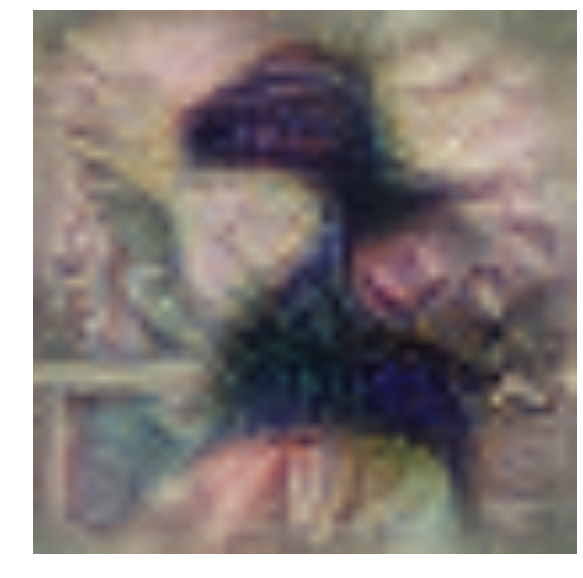

100%|██████████| 50/50 [00:02<00:00, 17.30it/s]


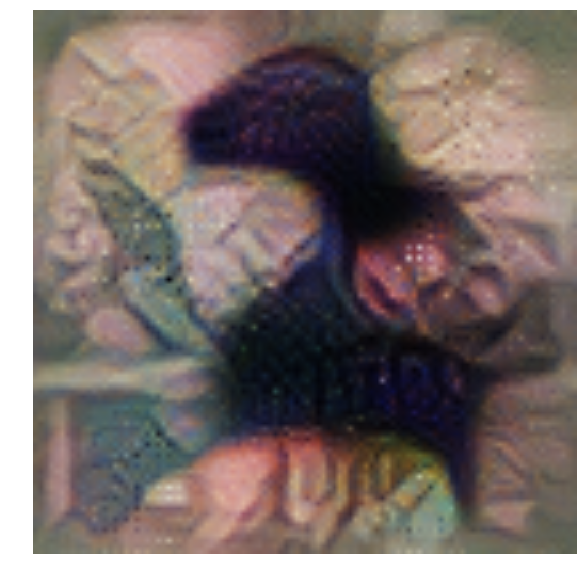

100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


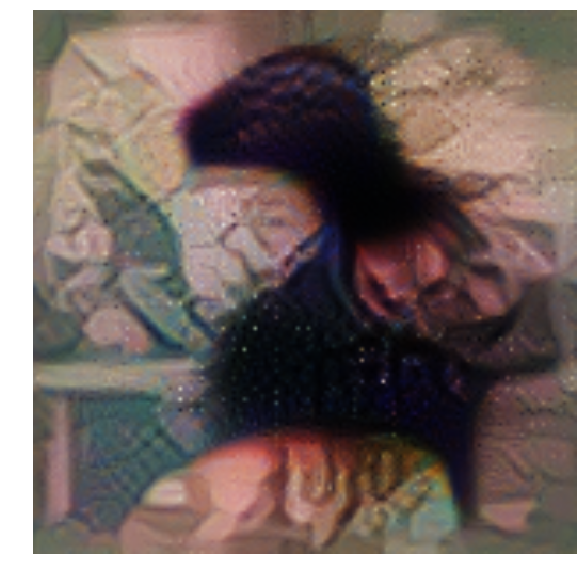

100%|██████████| 50/50 [00:05<00:00,  9.89it/s]


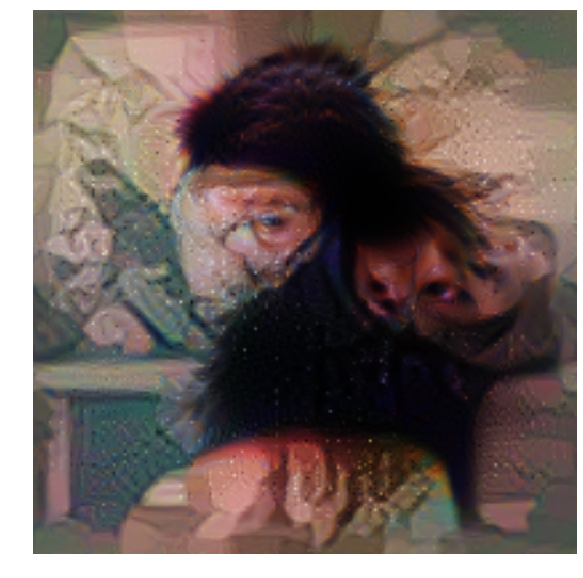

100%|██████████| 50/50 [00:06<00:00,  7.49it/s]


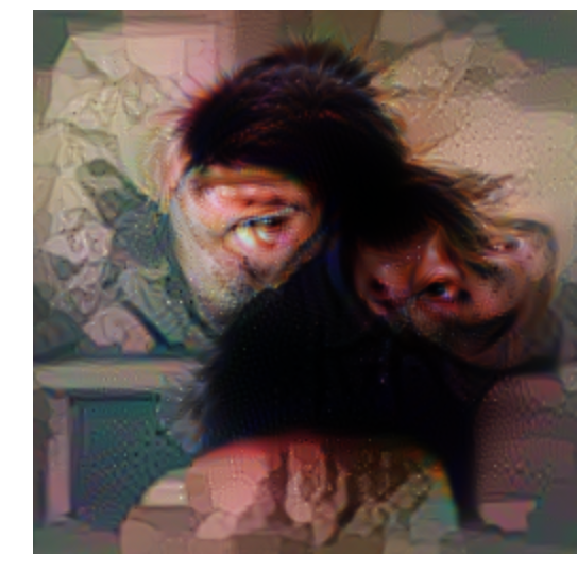

100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


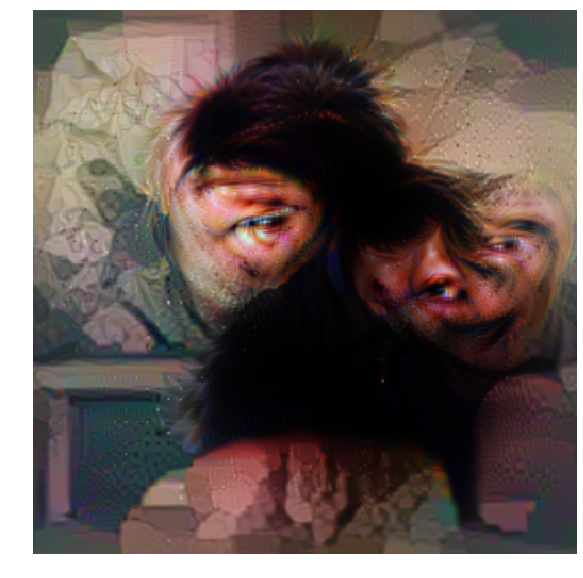

100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


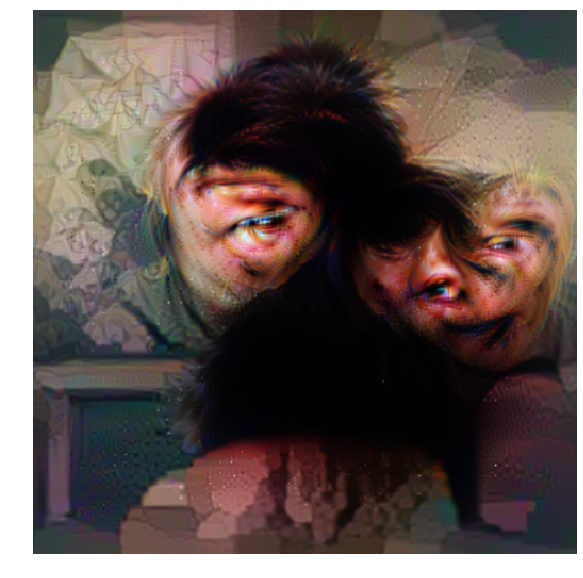

100%|██████████| 50/50 [00:14<00:00,  3.47it/s]


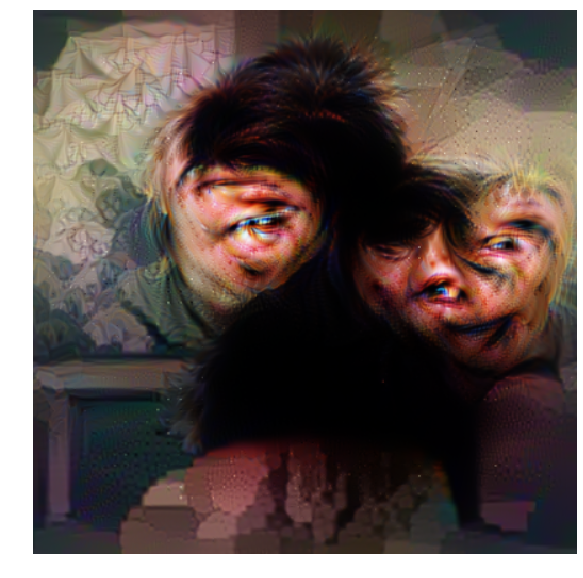

100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


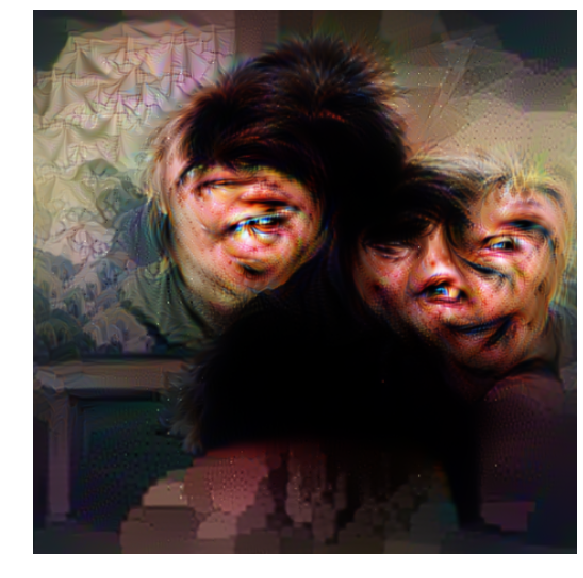

100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


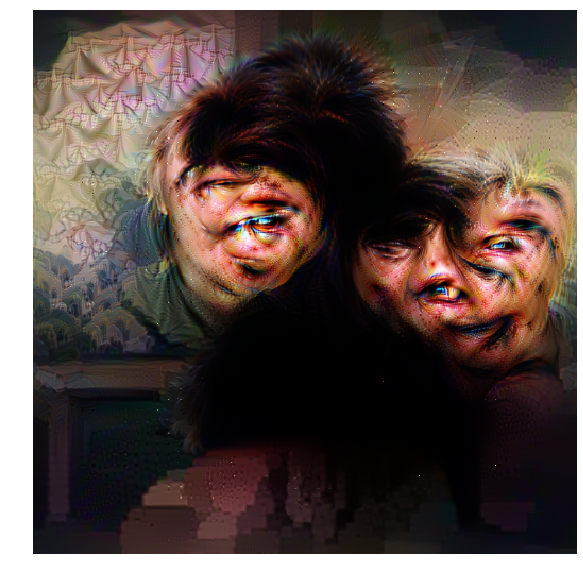

In [7]:
interp = sumie.transforms.Interpolate(0.1)
reverse = sumie.transforms.Interpolate(10)

im = sumie.Image(imsize, param='fft', transforms=[
                    sumie.transforms.PositionJitter(16),
                    sumie.transforms.ScaleJitter(1.01),
                    sumie.transforms.PositionJitter(16),
                    interp,
                    sumie.transforms.Normalise(),])

device = 'cuda'
im.to(device)
model.to(device)

style_list = [5, 7, 10, 14, 17, 24]
styles = [model.features[i] for i in style_list]
style = sumie.objectives.Style(sumie.utils.normalise(base_image).to(device), model.features, styles)
opt = sumie.Optimiser(im, model.features, style)
#opt.add_callback(change_scale)
for i in range(10):
    interp.factor = (i + 1)/10
    reverse.factor = 10/(i+1)
    thisIm = interp(sumie.utils.normalise(base_image).to(device))
    style_objective = sumie.objectives.Style(thisIm, model.features, styles)
    dream = sumie.objectives.DeepDream(model.features[26])
    combined = sumie.objectives.Composite((style_objective, dream), weights=(1, 1e-6))
    opt.objective = combined
    opt.run(iterations=50, lr=0.05, progress=True, output='tmp')
    sumie.vis.show(reverse(interp(im.get_image())), figsize = (10, 10))

tensor(-0.0009, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<MulBackward0>)


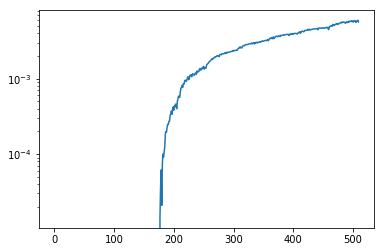

In [8]:
plt.semilogy([1*x.item() for x in opt.history])
w = combined.weights
for child, wi in zip(combined.children, w):
    print(wi*child.objective)

In [9]:
sumie.io.save(im.get_image(), 'style_dream.png')